# Classifying Postive and Negative Sentiments using Light GBM

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import os
import re
import contractions
import zipfile

In [76]:
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sns.set_style('darkgrid')

In [22]:
os.listdir()

['model_fit.ipynb', 'IMDB Dataset.csv.zip']

In [96]:
# import input file
zf = zipfile.ZipFile('/content/drive/My Drive/Kaggle (1)/imdb_sentiment_classification/IMDB Dataset.csv.zip') 
data = pd.read_csv(zf.open('IMDB Dataset.csv'))

In [97]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [64]:
data.shape

(50000, 2)

In [65]:
data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

Distribution of Postive and Negative reviews is uniform, hence we won't face any class imbalance issue

### Adding a feature as length of char in the review

In [98]:
# New column for length of review
data['length']=data['review'].str.len()

In [99]:
data.loc[10, 'review']

'Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines.<br /><br />At first it was very odd and pretty funny but as the movie progressed I didn\'t find the jokes or oddness funny anymore.<br /><br />Its a low budget film (thats never a problem in itself), there were some pretty interesting characters, but eventually I just lost interest.<br /><br />I imagine this film would appeal to a stoner who is currently partaking.<br /><br />For something similar but better try "Brother from another planet"'

In [81]:
print("Sentiment :", data.loc[10, 'sentiment'])

Sentiment : negative


### Replace special char `<br /><br />` with space

In [102]:
data['review'] = data['review'].str.replace('<br /><br />',' ')

In [103]:
data.loc[10, 'review']

'Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines. At first it was very odd and pretty funny but as the movie progressed I didn\'t find the jokes or oddness funny anymore. Its a low budget film (thats never a problem in itself), there were some pretty interesting characters, but eventually I just lost interest. I imagine this film would appeal to a stoner who is currently partaking. For something similar but better try "Brother from another planet"'

### Expanding contractions like `hadn't, haven't, didn't ->had not, have not, did not` in the reviews

In [110]:
# expanding the contractions
data['review'] = data['review'].apply(lambda x: contractions.fix(x))

In [123]:
# data.loc[135, 'review']

In [114]:
# Converting into lower case
data['review'] = data['review'].str.lower()

### Replace everything except alphabets with space

In [121]:
data['review'] = data['review'].str.replace(r'[^a-zA-Z]',' ')

### Tockenizing the text

In [125]:
def tokenize(text):
    split=re.split("\W+",text) 
    return split

In [127]:
data['review_split'] = data['review'].apply(lambda x: tokenize(x))

In [128]:
data.head()

,review,sentiment,length,review_split
0,one of the other reviewers has mentioned that ...,positive,1761,"[one, of, the, other, reviewers, has, mentione..."
1,a wonderful little production the filming te...,positive,998,"[a, wonderful, little, production, the, filmin..."
2,i thought this was a wonderful way to spend ti...,positive,926,"[i, thought, this, was, a, wonderful, way, to,..."
3,basically there is a family where a little boy...,negative,748,"[basically, there, is, a, family, where, a, li..."
4,petter mattei s love in the time of money is...,positive,1317,"[petter, mattei, s, love, in, the, time, of, m..."


### Removing stopwords

In [131]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [132]:
stopword = nltk.corpus.stopwords.words('english')

In [133]:
def remove_stopwords(text):
    text=[word for word in text if word not in stopword]
    return text

In [135]:
data['review_wo_sw'] = data['review_split'].apply(lambda x: remove_stopwords(x))

In [136]:
data.head()

,review,sentiment,length,review_split,review_wo_sw
0,one of the other reviewers has mentioned that ...,positive,1761,"[one, of, the, other, reviewers, has, mentione...","[one, reviewers, mentioned, watching, oz, epis..."
1,a wonderful little production the filming te...,positive,998,"[a, wonderful, little, production, the, filmin...","[wonderful, little, production, filming, techn..."
2,i thought this was a wonderful way to spend ti...,positive,926,"[i, thought, this, was, a, wonderful, way, to,...","[thought, wonderful, way, spend, time, hot, su..."
3,basically there is a family where a little boy...,negative,748,"[basically, there, is, a, family, where, a, li...","[basically, family, little, boy, jake, thinks,..."
4,petter mattei s love in the time of money is...,positive,1317,"[petter, mattei, s, love, in, the, time, of, m...","[petter, mattei, love, time, money, visually, ..."


### Removing words with length less than 3

In [143]:
# removing words with length less than 3
def remove_smallwords(text, length = 2):
    text=[word for word in text if len(word) > length]
    return text

In [147]:
data['review_wo_sw'] = data['review_wo_sw'].apply(lambda x: remove_smallwords(x))

### Applying Lemmatization (grouping together the inflected)

In [198]:
from nltk.corpus import wordnet

In [163]:
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [164]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [179]:
from nltk import pos_tag, word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [202]:
def get_wordnet_pos(treebank_tag):
  """
  return WORDNET POS compliance to WORDENT lemmatization (a,n,r,v) 
  """
  if treebank_tag.startswith('J'):
      return wordnet.ADJ
  elif treebank_tag.startswith('V'):
      return wordnet.VERB
  elif treebank_tag.startswith('N'):
      return wordnet.NOUN
  elif treebank_tag.startswith('R'):
      return wordnet.ADV
  else:
      # As default pos in lemmatization is Noun
      return wordnet.NOUN

In [240]:
def wordnet_tagging(word):
  #word = list(word)
  postg = pos_tag(word)
  wntag = get_wordnet_pos(postg[0][1])
  return wntag

In [247]:
from sklearn.feature_extraction.text import TfidfVectorizer

#### Applying lemmatization on each word using its POS tag

In [242]:
corpus = []

for i in range(0, len(data)):
  message = data['review_wo_sw'][i]
  message = [lemmatizer.lemmatize(word, wordnet_tagging([word])) for word in message]
  message = ' '.join(message)
  corpus.append(message)

### Applying TFiDF vectorizer 

In [248]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus)

In [250]:
data['sentiment'].replace({'negative':0,'positive':1},inplace=True)

In [251]:
y = data['sentiment']

### Spliting data into Train Test and Building Light GBM model

In [253]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [254]:
# build the lightgbm model
import lightgbm as lgb
classifier = lgb.LGBMClassifier()
classifier.fit(X_train, y_train)

LGBMClassifier()

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      5035
           1       0.85      0.86      0.85      4965

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

Accuracy of LightGBM Model: 85.36 %


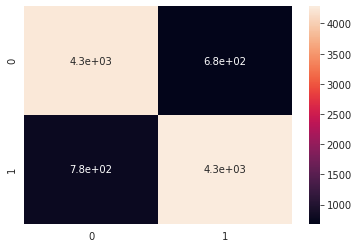

In [255]:
y_pred = classifier.predict(X_test)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
acc = accuracy_score(y_pred, y_test)
report = classification_report(y_test, y_pred)
print(report)
cm = confusion_matrix(y_pred, y_test)
sns.heatmap(cm, annot=True)
print("Accuracy of LightGBM Model:", acc*100,"%")

## LGBM giving 85% accuracy.